Група вимог_1: 
1. Отримання вхідних даних із властивостями, заданими в Лр_1; 
2. Модель вхідних даних із аномальними вимірами; 
3. Очищення вхідних даних від аномальних вимірів. Спосіб виявлення аномалій та 
очищення обрати самостійно; 
4.  Визначення  показників  якості  та  оптимізація  моделі  (вибір  моделі  залежно  від 
значення показника якості). Показник якості та спосіб оптимізації обрати самостійно. 
5.  Статистичне  навчання  поліноміальної  моделі  за  методом  найменших  квадратів 
(МНК  –  LSM)  –  поліноміальна  регресія  для  вхідних  даних,  отриманих  в  п.1,2.  Спосіб 
реалізації МНК обрати самостійно; 
6. Прогнозування (екстраполяцію) параметрів досліджуваного процесу за «навченою» 
у п.5 моделлю на 0,5 інтервалу спостереження (об’єму вибірки); 
7. Провести аналіз отриманих результатів та верифікацію розробленого скрипта. 

Група вимог_3:
1. Здійснити розробку власного алгоритму виявлення аномальних вимірів та / або «навчання» параметрів відомих алгоритмів «бачити» властивості статистичної вибірки.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import math as mt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

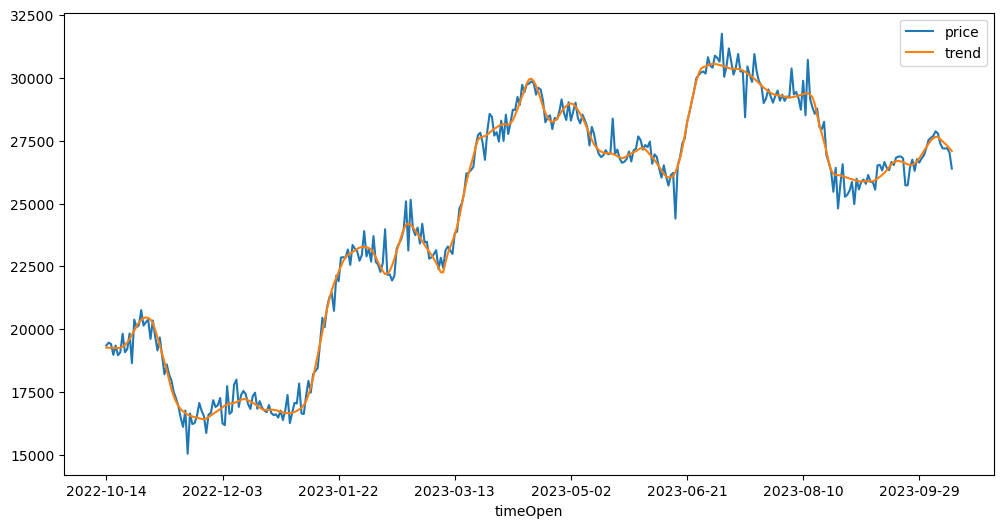

In [2]:
trend_df = pd.read_csv('trend_model.csv')
residual_df = pd.read_csv('residuals_model.csv')

combined_df = pd.DataFrame()
combined_df['date'] = trend_df['timeOpen']
combined_df['price'] = trend_df['trend'] + residual_df['residuals']
combined_df.set_index('date', inplace=True)
fig, ax = plt.subplots(figsize = (12, 6))
combined_df.plot( ax=ax)
trend_df.plot(x='timeOpen', y='trend', ax=ax)

combined_df.reset_index( inplace=True)

<Axes: >

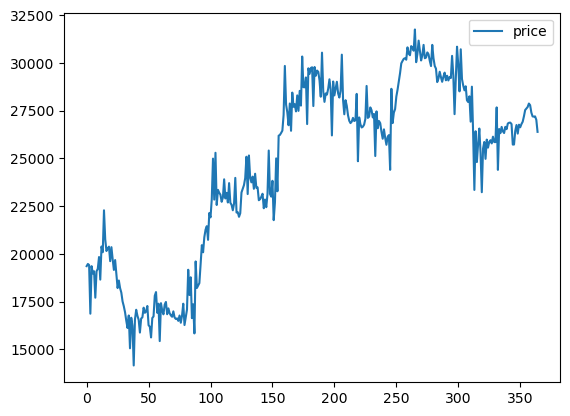

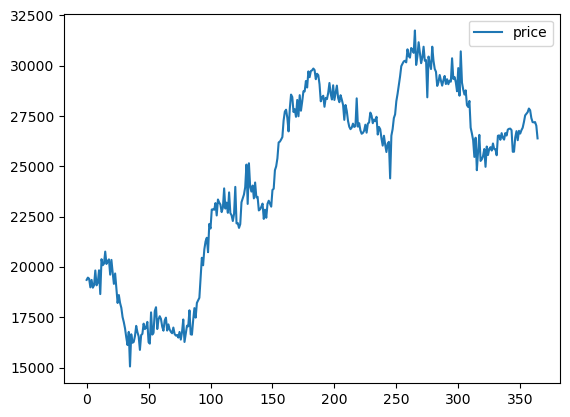

In [3]:
# Set the threshold for the anomaly as a multiple of the standard deviation
threshold = 5  
anomaly_percentage = 0.1 # 10% of total data
price_std = np.std(residual_df['residuals'])

total_data = len(combined_df)
num_anomalies = int(total_data * anomaly_percentage)  
anomaly_indices = np.random.choice(np.arange(total_data), size=num_anomalies, replace=False)

combined_df_with_anomalies = combined_df.copy()
for index in anomaly_indices:
    sign = np.random.choice([-1, 1])
    combined_df_with_anomalies.loc[index, 'price'] += sign * threshold * price_std

combined_df_with_anomalies.plot()
combined_df.plot()

In [4]:
def Sliding_Window_AV_Detect_medium (S0, n_Wind, Q):
    # ---- параметри циклів ----
    iter = len(S0)
    j_Wind=mt.ceil(iter-n_Wind)+1
    S0_Wind=np.zeros((n_Wind))
    # -------- еталон  ---------
    j=0
    for i in range(n_Wind):
        l = (j + i)
        S0_Wind[i] = S0[l]
        dS_standart = np.var(S0_Wind)
        scvS_standart = mt.sqrt(dS_standart)
    # ---- ковзне вікно ---------
    for j in range(j_Wind):
        for i in range(n_Wind):
            l=(j+i)
            S0_Wind[i] = S0[l]
    # - Стат хар ковзного вікна --
        mS = np.median(S0_Wind)
        dS = np.var(S0_Wind)
        scvS = mt.sqrt(dS)
    # --- детекція та заміна АВ --
        if scvS  > (Q*scvS_standart):
            # детектор виявлення АВ
            S0[l]=mS
    return S0

In [5]:
def sliding_window_anomaly_detection(data, window_size, threshold):
    result = data.copy()
    # standard deviation of the initial window
    previous_std = np.std(result[:window_size])
    
    # slide the window across the data
    for i in range(len(result) - window_size + 1):
        window = result[i : i + window_size]
        window_std = np.std(window)

        if window_std > threshold * previous_std:
            result[i + window_size - 1] = np.median(window)
        previous_std = window_std
    
    return result

In [6]:
def gridsearch(func_name ):
    # Define the ranges for threshold and window_size
    thresholds = np.linspace(0.1, 2.0, 20)  # Change these values as needed
    window_sizes = range(1, 15)  # Change these values as needed

    # Initialize variables to store the best parameters and the smallest error
    best_threshold = None
    best_window_size = None
    smallest_error = np.inf

    # Grid search over all combinations of threshold and window_size
    for threshold in thresholds:
        for window_size in window_sizes:
            cleaned_data = sliding_window_anomaly_detection(combined_df_with_anomalies['price'].values, window_size, threshold)
            error = mean_squared_error(combined_df['price'].values, cleaned_data)
            
            if error < smallest_error:
                best_threshold, best_window_size, smallest_error = threshold, window_size, error
                # print(best_threshold, best_window_size, smallest_error)
                
    return best_threshold, best_window_size, smallest_error

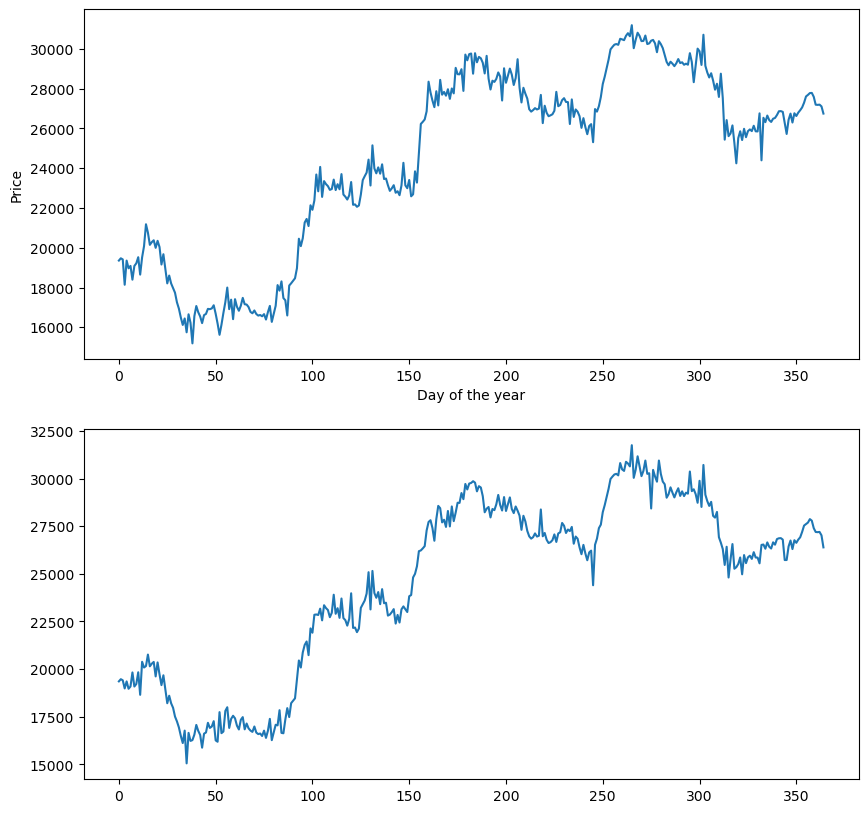

In [7]:
sw1_threshold, sw1_window_size, sw1_smallest_error = gridsearch(sliding_window_anomaly_detection)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
sw1_cleaned_data = sliding_window_anomaly_detection(combined_df_with_anomalies['price'].copy(), sw1_window_size, sw1_threshold)

ax1.plot(sw1_cleaned_data, label='Cleaned data')
ax1.set_xlabel('Day of the year')
ax1.set_ylabel('Price')

ax2.plot( combined_df['price'], label='Original data')
# sw2_threshold, sw2_window_size, sw2_smallest_error = gridsearch(Sliding_Window_AV_Detect_medium)
# sw2_cleaned_data = Sliding_Window_AV_Detect_medium(combined_df_with_anomalies['price'].copy(), sw2_window_size, sw2_threshold)
# ax2.plot(sw2_cleaned_data)

In [8]:
print('Best threshold: ', sw1_threshold)
print('Best window size: ', sw1_window_size)
print('Smallest error: ', sw1_smallest_error)

Best threshold:  1.5999999999999999
Best window size:  2
Smallest error:  217973.882353742


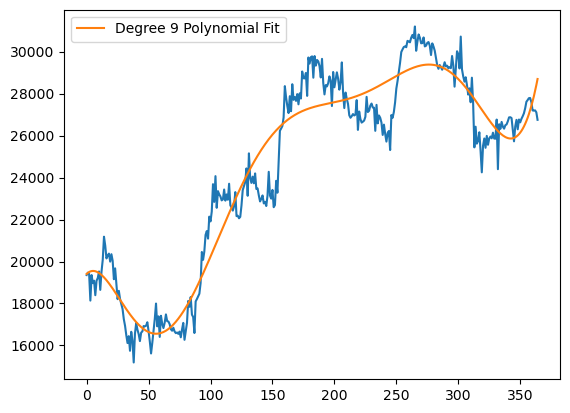

In [9]:
degrees = range(1, 10)  # Change the range of degrees as needed

best_degree = None
smallest_error = np.inf

for degree in degrees:
    coefficients = np.polyfit(range(len(sw1_cleaned_data)), sw1_cleaned_data, degree)
    polynomial = np.poly1d(coefficients)
    
    error = mean_squared_error(sw1_cleaned_data, polynomial(range(len(sw1_cleaned_data))))

    if error < smallest_error:
        best_degree = degree
        smallest_error = error

plt.plot(sw1_cleaned_data)
plt.plot(polynomial(range(len(sw1_cleaned_data))), label=f'Degree {best_degree} Polynomial Fit')
plt.legend()
plt.show()


In [16]:
coefficients = np.polyfit(range(len(sw1_cleaned_data)), sw1_cleaned_data, 9)
polynomial = np.poly1d(coefficients)

# Calculate the R2 score
r2 = r2_score(sw1_cleaned_data, polynomial(range(len(sw1_cleaned_data))))
print('R2 score: ', r2)


R2 score:  0.9255400736004012


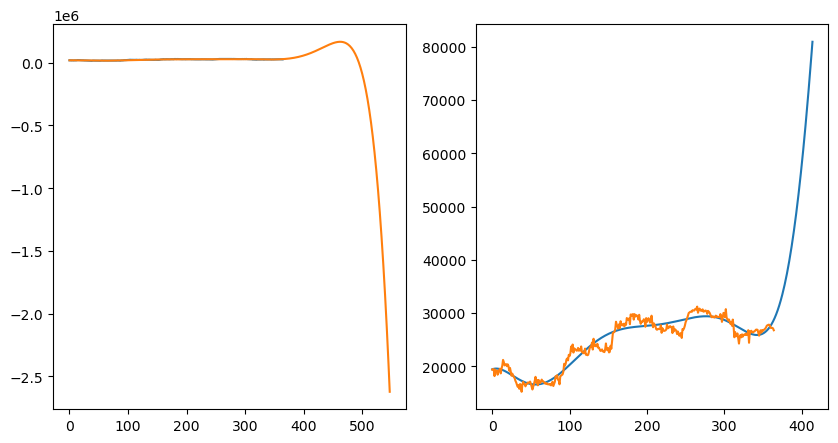

In [14]:

predictions_long = np.polyval(coefficients, range(round(len(sw1_cleaned_data)*1.5)))
predictions_short = np.polyval(coefficients, range(round(len(sw1_cleaned_data)+50)))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(sw1_cleaned_data)
ax[0].plot(predictions_long, label='Long-term predictions')
ax[1].plot(predictions_short, label='Short-term predictions')
ax[1].plot(sw1_cleaned_data)
plt.show()


Experimental part where different techniques for approximation and anomaly detection were explored.

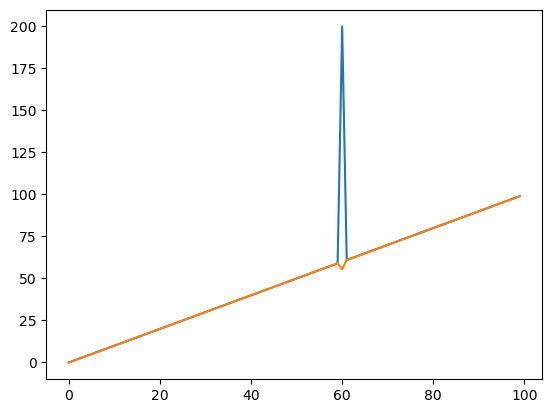

In [12]:
array = list(range(0, 100))
array[60]=200
plt.plot(array)
test = sliding_window_anomaly_detection(array, 10, 3)
plt.plot(test)

[ 0.09041096 -0.08493151  0.08493151  0.0739726  -0.0739726  -0.05479452
  0.05479452 -0.06849315  0.06849315  0.04657534 -0.04657534  0.05205479
 -0.05205479  0.00821918 -0.00821918 -0.05753425  0.05753425 -0.04383562
  0.04383562 -0.03287671  0.03287671 -0.04931507  0.04931507  0.02739726
 -0.02739726 -0.01917808  0.01917808 -0.04109589  0.04109589 -0.02191781
  0.02191781 -0.03561644  0.03561644 -0.03835616  0.03835616 -0.03013699
  0.03013699 -0.02465753  0.02465753  0.01643836 -0.01643836 -0.01369863
  0.01369863 -0.0109589   0.0109589   0.00547945 -0.00547945  0.00273973
 -0.00273973  0.        ]


c:\Users\vikto\miniconda3\envs\venv1\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\vikto\miniconda3\envs\venv1\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


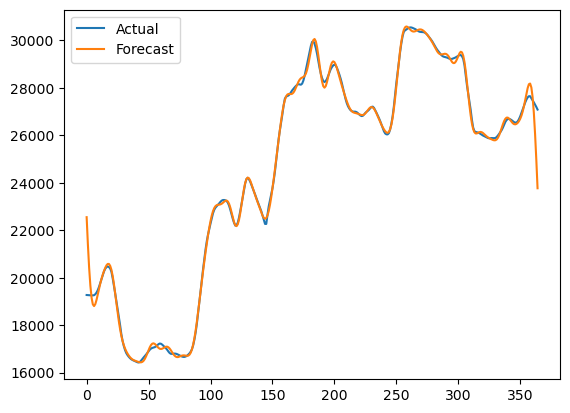

In [13]:
# Apply the Fourier Transform
trend_fft = np.fft.fft(trend_df['trend'])

# Compute the frequencies and amplitudes
frequencies = np.fft.fftfreq(len(trend_df))
amplitudes = np.abs(trend_fft)

# Identify the top 10 frequencies
top_frequencies = frequencies[np.argsort(amplitudes)[-50:]]
print(top_frequencies)

# Initialize a new FFT array with zeros
trend_fft_reconstructed = np.zeros(len(trend_df), dtype=complex)

# Set the elements at the indices corresponding to the top frequencies
for freq in top_frequencies:
    trend_fft_reconstructed[frequencies == freq] = trend_fft[frequencies == freq]

# Apply the IFFT
forecast = np.fft.ifft(trend_fft_reconstructed)
# Plot the forecast
plt.plot(trend_df.index, trend_df['trend'], label='Actual')
plt.plot(trend_df.index, forecast, label='Forecast')
plt.legend()
plt.show()